<a href="https://colab.research.google.com/github/ahmedSadoun/colab-project/blob/main/Inceptionresnetv2success.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#load kaggle api
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#download dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


100% 2.29G/2.29G [00:32<00:00, 69.4MB/s]
100% 2.29G/2.29G [00:32<00:00, 75.9MB/s]


In [ ]:
#extracte data from zipfile
import zipfile
zf = "/content/chest-xray-pneumonia.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
# Import Libraries
import os
import cv2
import scipy
import numpy as np
from tqdm import tqdm
from random import shuffle
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.applications import InceptionResNetV2
from keras.models import Sequential, Model
from keras.layers import  Dropout,Dense,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [ ]:
# File Paths
input_path = '/content/dataset/cnn/pneumonia_revamped/chest_xray/'


In [ ]:
# File Contents
for _set in ['train', 'val', 'test']:
    normal = len(os.listdir(input_path + _set + '/NORMAL'))
    infected = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('The {} folder contains {} Normal and {} Pneumonia images.'.format(_set, normal, infected))

The train folder contains 1341 Normal and 3875 Pneumonia images.
The val folder contains 8 Normal and 8 Pneumonia images.
The test folder contains 234 Normal and 390 Pneumonia images.


In [ ]:
img_dims=150
batch_size=32
# Preprocesing Data Function

# Data Augmentation for Train & Test Images
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    shear_range = 0.2,      
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    horizontal_flip = True)

test_datagen = ImageDataGenerator(
    rescale = 1./255)

train_images = train_datagen.flow_from_directory(
    directory = input_path + 'train', 
    target_size = (img_dims, img_dims), 
    batch_size = batch_size, 
    class_mode = 'binary', 
    shuffle = True)

test_images = test_datagen.flow_from_directory(
    directory = input_path + 'test', 
    target_size = (img_dims, img_dims), 
    batch_size = batch_size, 
    class_mode = 'binary', 
    shuffle = True)

# I'm created these lists for make prediction on test image and showing confusion matrix.
train_labels = []
test_labels = []

for file_name in ['/NORMAL/', '/PNEUMONIA/']:
    for img in (os.listdir(input_path + 'test' + file_name)):
        img = plt.imread(input_path + 'test' + file_name+img)
        img = cv2.resize(img, (img_dims, img_dims))
        img = np.dstack([img, img, img])
        img = img.astype('float32') / 255
        if file_name == '/NORMAL/':
            label = 0
        elif file_name == '/PNEUMONIA/':
            label = 1
        train_labels.append(img)
        test_labels.append(label)
    
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)



Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
 test_images = test_datagen.flow_from_directory(
        directory = input_path + 'test', 
        target_size = (150, 150), 
        batch_size = 32, 
        class_mode = 'binary', 
        shuffle = False)

In [ ]:
# Set Transfer Model
transfer_model = InceptionResNetV2(weights= 'imagenet', include_top = False, input_shape = (img_dims, img_dims, 3))

219062272/219055592 [==============================] - 2s 0us/step


In [ ]:
# Add new Layers
new_model = Sequential()
new_model.add(GlobalAveragePooling2D(input_shape = transfer_model.output_shape[1:], data_format=None)),  
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Combine Models
model = Model(inputs=transfer_model.input, outputs=new_model(transfer_model.output))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# Set Optimizer
optimizer = Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08,decay = 0.0)

# Compile Model
model.compile(
    optimizer= optimizer,
    loss='binary_crossentropy',
    metrics=['acc'])

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)

2.4.1


In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint


early = EarlyStopping(monitor="loss", mode="min",min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]
train_steps=train_images.samples /(32*2)

print(train_steps)
# Fit the Model
history = model.fit_generator(
            train_images,
            steps_per_epoch = train_steps, 
            epochs = 100, 
            validation_data = test_images,
            validation_steps = test_images.samples // batch_size , callbacks=callbacks_list)

81.5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
81/81 [==============================] - 101s 632ms/step - loss: 0.3810 - acc: 0.8184 - val_loss: 0.7564 - val_acc: 0.8602
Epoch 2/100
81/81 [==============================] - 50s 613ms/step - loss: 0.1302 - acc: 0.9522 - val_loss: 0.7735 - val_acc: 0.8059
Epoch 3/100
81/81 [==============================] - 51s 618ms/step - loss: 0.1176 - acc: 0.9568 - val_loss: 0.2637 - val_acc: 0.9030
Epoch 4/100
81/81 [==============================] - 50s 611ms/step - loss: 0.1012 - acc: 0.9600 - val_loss: 0.3040 - val_acc: 0.8865
Epoch 5/100
81/81 [==============================] - 49s 600ms/step - loss: 0.0922 - acc: 0.9695 - val_loss: 0.4675 - val_acc: 0.8372
Epoch 6/100
81/81 [==============================] - 50s 612ms/step - loss: 0.0769 - acc: 0.9717 - val_loss: 0.3612 - val_acc: 0.8651
Epoch 7/100
81/81 [==============================] - 49s 601ms/step - loss: 0.0576 - acc: 0.9806 - val_loss: 0.3618 - val_acc: 0.8684
Epoch 8/100
81/81 [==============================] - 50s 607m

In [ ]:
history.history
print(history.history['acc'])

[0.894817054271698, 0.9569360017776489, 0.9550305008888245, 0.9615091681480408, 0.9657012224197388, 0.9668444991111755, 0.9771341681480408, 0.9778963327407837, 0.9767530560493469, 0.9809451103210449, 0.984375, 0.9866616129875183, 0.9786585569381714, 0.9809451103210449, 0.9855182766914368, 0.9878048896789551, 0.9889481663703918, 0.9900914430618286, 0.9908536672592163, 0.9919969439506531, 0.9893292784690857, 0.988567054271698, 0.9900914430618286]


In [ ]:
score,acc=model.evaluate(test_images)
print("score",score)
print("accuracy",acc)

20/20 [==============================] - 7s 325ms/step - loss: 0.1996 - acc: 0.9375
score 0.1995776742696762
accuracy 0.9375


In [ ]:
# Visualize Loss and Accuracy Rates

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['acc', 'loss']):
    plt.style.use("ggplot")
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['Train', 'Val'])



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
# Predictions, Confusion Matrix & Performance Metrics

# Prediction on Model
Y_pred = model.predict(train_labels)
Y_pred = [ 1 if y >= 0.5 else 0 for y in Y_pred]

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, Y_pred)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

# Performance Metrics
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
print('Confusion Matrix :')
print(cm) 
print('Accuracy Score :',accuracy_score(test_labels, Y_pred))
print('Report : ')
print(classification_report(test_labels, Y_pred))

In [ ]:
from keras.preprocessing.image import image

# Image Classifer Script
def predict_image(model, img_path, img_dims = 150):
    img = image.load_img(img_path, target_size = (img_dims, img_dims))
    plt.imshow(img)
    plt.show()
    img = image.img_to_array(img)
    x = np.expand_dims(img, axis=0) * 1./255
    score = model.predict(x)
    print('Predictions: ', score, 'NORMAL' if score < 0.5 else 'PNEUMONIA')

In [ ]:
# Test on Validation Images
predict_image(model,(input_path+'val/NORMAL/NORMAL2-IM-1431-0001.jpeg'))
predict_image(model,(input_path+'val/PNEUMONIA/person1947_bacteria_4876.jpeg'))

In [ ]:
# Save Model
model.save('drive/MyDrive/inceptionresnetv2')


In [ ]:
from tensorflow.keras.models import load_model
alexnet_path='/content/drive/MyDrive/project models/AlexNet_final_save.h5'
inception_resnet='/content/drive/MyDrive/project models/inceptionresnetv2.h5'
resnet='/content/drive/MyDrive/project models/resnet_final.h5'

model=load_model(resnet)

vgg16 224 224 
alex 227 227 
resnet 227 227 
inception 150 150 


Actual class: NORMAL
Predicted class: Pneumonia


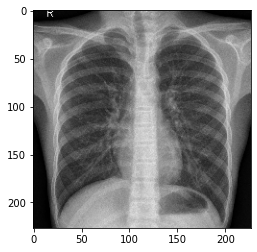

In [ ]:
from numpy import *
from glob import glob
import os
import numpy as np
import pandas as pd
import random
from skimage.io import imread
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline

def choose_image_and_predict():
    normal_or_pneumonia = ['NORMAL','PNEUMONIA']
    folder_choice = (random.choice(normal_or_pneumonia))
    
    pneumonia_images = glob('/content/dataset/cnn/pneumonia_revamped/chest_xray/chest_xray/test/'+folder_choice+'/*')
    img_choice = (random.choice(pneumonia_images))

    img = load_img(img_choice, target_size=(227, 227))
    img = img_to_array(img)
    plt.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    pred_class = model.predict(x)
    
    pred = model.predict(x)
   
    print("Actual class:", folder_choice)
    if pred_class == 0:
        print("Predicted class: Normal")
        
        
    else:
        print("Predicted class: Pneumonia")
              
        
choose_image_and_predict()

In [ ]:

#nb_samples = test_dir.shape[0]
predict = model.predict(test_images)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

score, acc = model.evaluate(test_images,
                            batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

20/20 [==============================] - 10s 295ms/step - loss: 0.2404 - accuracy: 0.9301
Test score: 0.25900912284851074
Test accuracy: 0.9166666865348816


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
print('f1 score ',f1_score(predict.round(),test_images.classes,average='micro'))
print('accuracy ',accuracy_score(predict.round(),test_images.classes))
print('recall ',recall_score(predict.round(),test_images.classes,average=None))
print('precision ',precision_score(predict.round(),test_images.classes,average=None))

f1 score  0.5416666666666666
accuracy  0.5416666666666666
recall  [0.36597938 0.62093023]
precision  [0.3034188  0.68461538]


AUC Value  :  0.49401709401709404


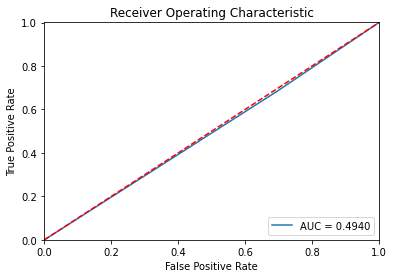

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fprValue2, tprValue2, thresholdsValue2 = roc_curve(test_images.classes,predict.round())
AUCValue = auc(fprValue2, tprValue2)
print('AUC Value  : ', AUCValue)
plt.title('Receiver Operating Characteristic')
plt.plot(fprValue2, tprValue2, label='AUC = %0.4f'% AUCValue)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

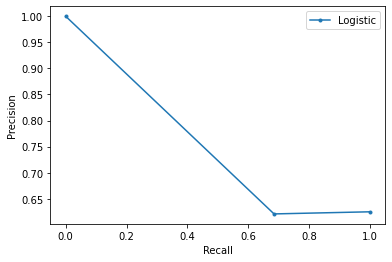

In [ ]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
precision, recall, _ = precision_recall_curve(test_images.classes, predict.round())
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

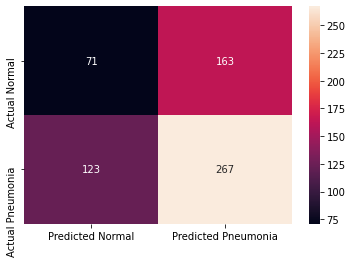

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
cm = pd.DataFrame(data=confusion_matrix(test_images.classes, predict.round()),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(test_images.classes)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [ ]:
print(predict.round())